# EDA of climate data
Belonging Repository: https://github.com/mic1899/earth_surface_temperature/tree/dev_main

Belonging Data Source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


In [58]:
# Loading the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os # accessing directory structure

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter

%matplotlib inline

# Defining some general plot settings
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Class for colored terminal outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   ITALIC = '\033[3m'

In [157]:
# Defining the file names and path
PATH = "/home/rapunzel/home/projects/earth_surface_temperature/data/"
shorts = ["city", "country", "majorcity", "global", "state"]
datasets = dict(zip(shorts,os.listdir(PATH)))
# loading the different data sets
i = shorts[0]
df = pd.read_csv(PATH+datasets[i], delimiter=',')
df.name = i



In [102]:
def time_conv(df):
    # Convert timestamp to datetime object
    # Extract additional features from timestamp column
    df = df.assign(
        date = lambda x: pd.to_datetime(x['dt']),
        year = lambda x: x['date'].dt.year,
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        dayofyear = lambda x: x['date'].dt.dayofyear
    )
    return df
df = time_conv(df)

In [ ]:
def rm_nan(df, column):
    df[column].fillna(df[column].mean(), inplace=True)
    return df

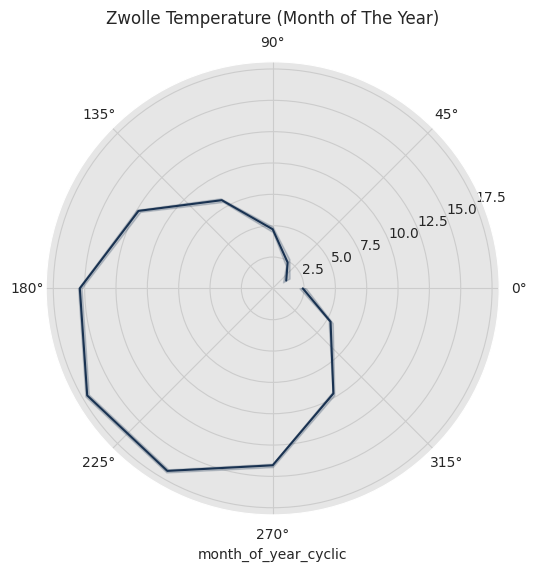

In [174]:
def plot_seasons(df, city):    
    # Polar plot for seasonality 
    ax = plt.subplot(111, projection='polar')
    daily_data_df = df[df.City==city]

    # Convert and plot data
    daily_data_df \
        .assign(month_of_year_cyclic = lambda x: x['month'].transform(lambda x: 2*np.pi*x/12)) \
        .pipe((sns.lineplot, 'data'), 
            x='month_of_year_cyclic', 
            y='AverageTemperature', 
            ax=ax
        )

    ax.set_ylabel('')
    ax.set_title(city + ' Temperature (Month of The Year)', va='bottom');

plot_seasons(df, "Zwolle")

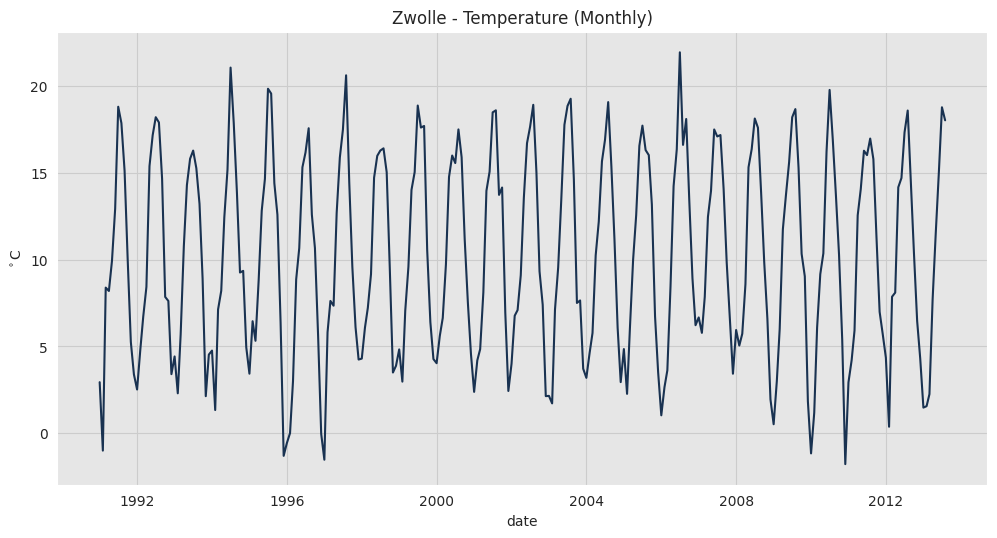

In [173]:
def plot_temp(df, city):
    daily_data_df = df[df.City==city]
    # Plot temperature on daily basis 
    fig, ax = plt.subplots()
    sns.lineplot(x='date', y='AverageTemperature', data=daily_data_df.reset_index(), ax=ax)
    ax.set(title=city + ' - Temperature (Monthly)', ylabel=r'$^\circ$C');

plot_temp(df.query("year>1990"), "Zwolle")

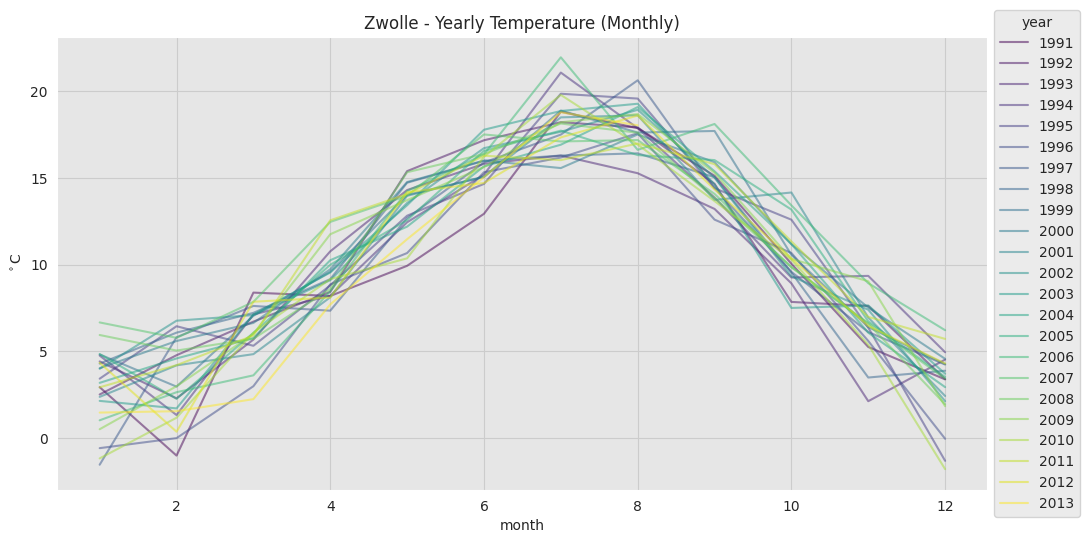

In [172]:
def plot_yearly_season(df, city):
    daily_data_df = df[df.City==city].dropna()
    # Plot yearly seasonality
    fig, ax = plt.subplots() 

    pd.pivot_table(data=daily_data_df[['year', 'month', 'AverageTemperature']], index='month', columns='year') \
        ['AverageTemperature'] \
        .plot(cmap='viridis', alpha=0.5, ax=ax)

    ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(title=city + ' - Yearly Temperature (Monthly)', ylabel=r'$^\circ$C');

plot_yearly_season(df.query("year>1990"), "Zwolle")

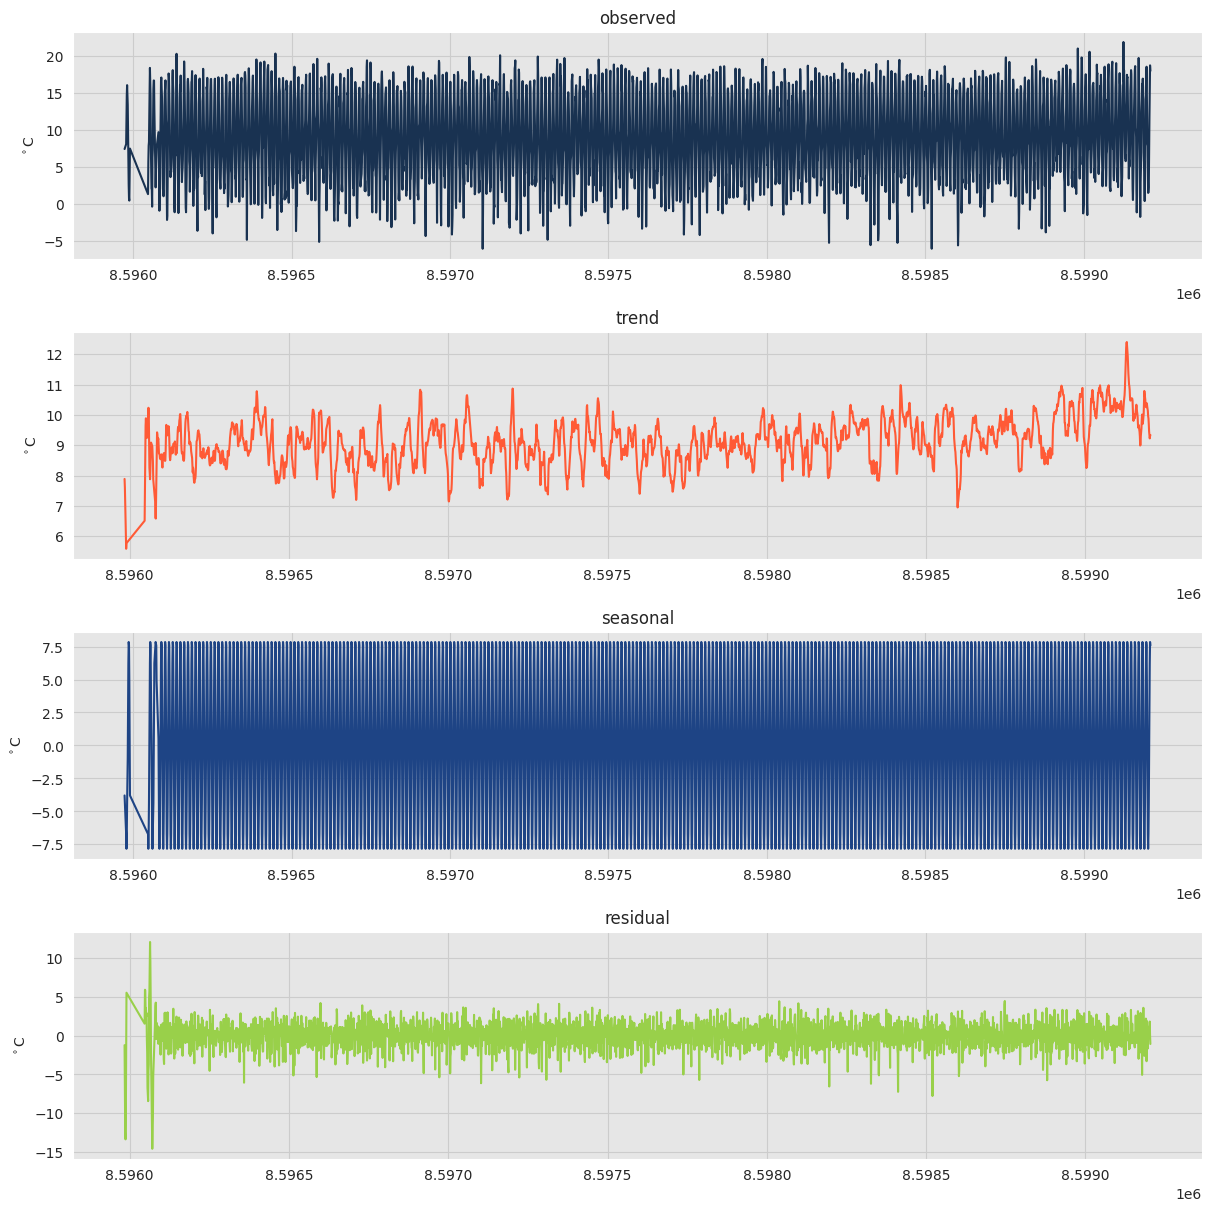

In [171]:
def trend_season_residual(df, city):
    daily_data_df = df[df.City==city]
    df = df.dropna(subset=["AverageTemperature"])
    # We use the parameter `period` = 12 to extract the yearly seasonality. 
    seas_decomp_yearly = seasonal_decompose(
        x=daily_data_df['AverageTemperature'], 
        model='additive', 
        period=12
    )

    # Plot data
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

    seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
    ax[0].set(title='observed', ylabel=r'$^\circ$C')
    seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
    ax[1].set(title='trend', ylabel=r'$^\circ$C')
    seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
    ax[2].set(title='seasonal', ylabel=r'$^\circ$C')
    seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
    ax[3].set(title='residual', ylabel=r'$^\circ$C');

trend_season_residual(df, "Zwolle")